### Binary Classification

In [21]:
# importing libraries
import math
import tensorflow as tf
import keras
from keras.layers import *
import numpy as np
import random
import io
import os
from sklearn.model_selection import train_test_split
from keras.activations import tanh, softmax, sigmoid
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
import random
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import (
    LSTM,
    LSTMCell,
    Input,
    Dense,
    concatenate,
    TimeDistributed,
    Flatten,
    Dropout,
    Masking,
    RepeatVector,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    multiply,
    Permute,
    Concatenate,
    Conv2D,
    Add,
    Activation,
    Lambda,
    BatchNormalization
)
from keras import backend as K, Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

In [22]:
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Select the first GPU (index 0)
        tf.config.set_visible_devices(gpus[5], 'GPU')

        # Optionally, limit GPU memory growth (prevents TensorFlow from consuming all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Using GPU:", gpus[5])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [23]:
# soft object
soft = np.asarray([1, 0])
# hard object
hard = np.asarray([0, 1])

In [24]:
# reading a numpy file
data_dir = './train_val_data'
samples_per_window = 30

def read_npy_files(directory):
  data = []
  labels = []
  for filename in os.listdir(directory):
    if filename.endswith(".npy"):
      base_name = os.path.splitext(filename)[0]
      data.append(np.load(os.path.join(directory, filename), allow_pickle = True))
      # print(np.asarray(data).shape)
      # for labelling
      label = []
      objects = ['phone cover', 'rubber', 'bottle']
      if any(object in filename for object in objects):
          label.append(np.tile(soft, (samples_per_window, 1)))
      else:
          label.append(np.tile(hard, (samples_per_window, 1)))
      label = np.asarray(label).reshape(samples_per_window, 2)
      # print(np.asarray(label).shape)
      labels.append(np.asarray(label))
  return data, labels

all_data, labels = read_npy_files(data_dir)

# converting to numpy array
all_data = np.asarray(all_data)[:, :, :, 1:]
labels = np.asarray(labels)

In [25]:
type(all_data), type(labels)

(numpy.ndarray, numpy.ndarray)

In [26]:
all_data.shape, labels.shape

((12, 8, 30, 3), (12, 30, 2))

In [27]:
all_data[0, 0 , 0 , ]

array([0.002595324954017997, 0.10000000149011612, 38.55552925554677],
      dtype=object)

In [28]:
train_all_data = []
val_all_data = []
test_all_data =[]
train_labels = []
val_labels = []
test_labels = []
total_samples = 8
val_samples = 1
test_samples = 1
train_samples = total_samples - val_samples - test_samples


for data in all_data:
  for i in range(train_samples):
    train_all_data.append(data[i])
  for i in range(val_samples):
    val_all_data.append(data[train_samples + i])
  for i in range(test_samples):
    test_all_data.append(data[train_samples + val_samples + i])

for label in labels:
  # label = np.expand_dims(label[1, :], axis = 0)
  # print(np.asarray(label).shape)
  for i in range(train_samples):
    train_labels.append(label[1, :])
  for i in range(val_samples):
    val_labels.append(label[1, :])
  for i in range(test_samples):
    test_labels.append(label[1, :])

In [29]:
np.asarray(train_all_data).shape

(72, 30, 3)

In [30]:
np.asarray(train_labels).shape

(72, 2)

In [31]:
np.asarray(val_all_data).shape

(12, 30, 3)

In [32]:
np.asarray(val_labels).shape

(12, 2)

In [33]:
np.asarray(test_all_data).shape

(12, 30, 3)

In [34]:
np.asarray(test_labels).shape

(12, 2)

In [35]:
labels[0][0]

array([1, 0])

In [36]:
# hyperpaprameters
TIME_STEPS = 30
input_dim  = 3
output_dim = 2

# UNITS_DENSE = 128
UNITS_LSTM = 2048

DROPOUT_STRENGTH = 0.2
RECURRENT_DROPOUT_STRENGTH = 0.4

BIAS_INITIALIZER = "ones"
KERNEL_INITIALIZER = "VarianceScaling"

In [37]:
class LSTM_cell:
    def __init__(self, time_steps = TIME_STEPS,
                 dim_2 = input_dim,
                 lstm_units=UNITS_LSTM,
                 dropout=DROPOUT_STRENGTH,
                 rec_dropout=RECURRENT_DROPOUT_STRENGTH,
                 kernel_initializer=KERNEL_INITIALIZER,
                 bias_initializer=BIAS_INITIALIZER):

        self.time_steps = time_steps
        self.dim_2 = dim_2

        self.dropout = dropout
        self.rec_dropout = rec_dropout
        self.bias_initializer = bias_initializer
        self.kernel_initializer = kernel_initializer

        self.lstm_units = lstm_units
        # self.dense_units = dense_units

    def input_encoding_lstm(self, inputs):
        lstm_input = inputs
        lstm_hidden_states, hidden_state, c = LSTM(
            self.lstm_units, kernel_initializer=self.kernel_initializer, return_sequences=True,
            return_state=True,
            recurrent_dropout=self.rec_dropout,
            bias_initializer=self.bias_initializer,
            name='lstm_output'
        )(lstm_input)

        context_features = Dense(output_dim)(hidden_state)
        out = softmax(context_features, axis = 1)
        return out

    def generate(self):
        input_to_lstm = Input(shape=(self.time_steps, self.dim_2), name='lstm_input')

        output_from_lstm = self.input_encoding_lstm(input_to_lstm)
        model = Model(inputs = input_to_lstm, outputs = output_from_lstm)
        return model

In [38]:
lstm = LSTM_cell()
model = lstm.generate()

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_output (LSTM)              │ [(None, 30, 2048),     │    16,809,984 │
│                                 │ (None, 2048), (None,   │               │
│                                 │ 2048)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,814,082 (64.14 MB)

 Trainable params: 16,814,082 (64.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3472 - f1_score: 0.3472 - loss: 0.7376 - precision_1: 0.3472 - recall_1: 0.3472
Epoch 1: val_f1_score improved from -inf to 0.75000, saving model to checkpoint_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.3472 - f1_score: 0.3472 - loss: 0.7376 - precision_1: 0.3472 - recall_1: 0.3472 - val_accuracy: 0.7500 - val_f1_score: 0.7500 - val_loss: 0.6318 - val_precision_1: 0.7500 - val_recall_1: 0.7500
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - f1_score: 0.7500 - loss: 0.6218 - precision_1: 0.7500 - recall_1: 0.7500
Epoch 2: val_f1_score improved from 0.75000 to 0.83333, saving model to checkpoint_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - f1_score: 0.7500 - loss: 0.6218 - precision_1: 0.7500 - recall_1: 0.7500 - val_accuracy: 0.8333 - val_f1_score: 0.8333 - val_loss: 0.5716 - val_precision_1: 0.8333 - val_recall_1: 0.8333
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

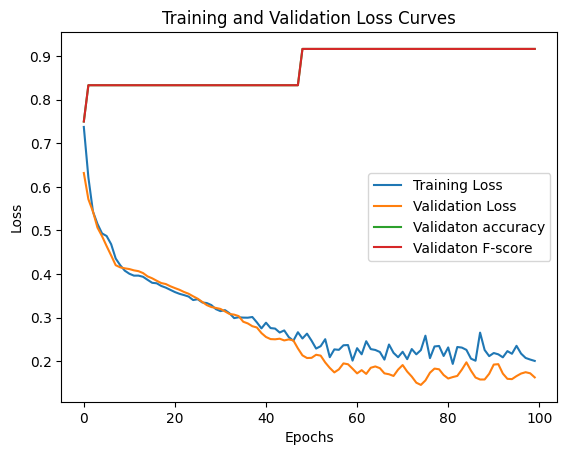

In [40]:
checkpoint_filepath = 'checkpoint_model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_f1_score',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False
)

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1

# Early stopping criteria
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall, f1_score])

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs = None):
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []
        self.precision = []
        self.recall = []
        self.f1 = []

    # def on_epoch_end(self, epoch, logs = None):
        # val_pred = tf.convert_to_tensor(np.round(self.model.predict(self.validation_data[0])))
        # print(val_pred)
        # flatten_val_pred = tf.reshape(val_pred, [-1])
        # print(flatten_val_pred)
        # val_true = self.validation_data[1]
        # print(val_true)
        # flatten_val_true = tf.reshape(val_true, [-1])
        # # print(f'Precision : {precision_score(val_true, val_pred, average=None)}')
        # self.precision.append(precision_score(val_true, val_pred, average='weighted'))
        # self.recall.append(recall_score(val_true, val_pred, average='weighted'))
        # self.f1.append(f1_score(val_true, val_pred, average='weighted'))
        # # Create a figure and two subplots
        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # # plotting the precison, recall and f1_score
        # ax1.plot(self.precision, label='Precision', marker = 'o', markersize = 4)
        # ax1.plot(self.recall, label='Recall', marker = 'o', markersize = 4)
        # ax1.plot(self.f1, label='F1 Score', marker = 'o', markersize = 4)
        # ax1.set_title('Confusion matrix metrics')
        # ax1.set_xlabel('Epochs')
        # ax1.set_ylabel('Score')
        # ax1.legend()
        # # plot the losses
        # self.train_losses.append(logs['loss'])
        # self.val_losses.append(logs['val_loss'])
        # self.val_acc.append(logs['val_accuracy'])
        # # print(self.train_losses, self.val_losses, self.val_acc)
        # ax2.plot(self.train_losses, label = 'training loss', marker = 'o', markersize = 4)
        # ax2.plot(self.val_losses, label = 'validation loss', marker = 'o', markersize = 4)
        # ax2.plot(self.val_acc, label = 'validation accuracy', marker = 'o', markersize = 4)
        # ax2.set_title('Training Loss And Validation Loss and accuracy curves')
        # ax2.set_xlabel('Epochs')
        # ax2.set_ylabel('Loss')
        # ax2.legend()
        # plt.show()
        # plot the losses
        # self.train_losses.append(logs['loss'])
        # self.val_losses.append(logs['val_loss'])
        # self.val_acc.append(logs['val_accuracy'])
        # print(self.train_losses, self.val_losses, self.val_acc)
        
        # plt.plot(self.train_losses, label = 'training loss', marker = 'o', markersize = 4)
        # plt.plot(self.val_losses, label = 'validation loss', marker = 'o', markersize = 4)
        # plt.plot(self.val_acc, label = 'validation accuracy', marker = 'o', markersize = 4)
        # plt.title('Training Loss And Validation Loss and accuracy curves')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.show()


train_all_data = tf.convert_to_tensor(train_all_data)
train_labels = tf.convert_to_tensor(train_labels)
val_all_data = tf.convert_to_tensor(val_all_data)
val_labels = tf.convert_to_tensor(val_labels)
validation_data=(val_all_data, val_labels)

history = model.fit(train_all_data, train_labels, epochs = 100, batch_size = 128,
          validation_data = validation_data, callbacks = [model_checkpoint_callback, MetricsCallback(validation_data)])

# for tracking the maximum validation accuracy ata particular epoch
# val_acc_list = np.asarray(history.history['val_accuracy'])
# max_val_acc = (val_acc_list).max()

# print(max_val_acc, np.where(val_acc_list == max_val_acc)[0] + 1)

# plotting the graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validaton accuracy')
plt.plot(history.history['val_f1_score'], label='Validaton F-score')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()